<a href="https://colab.research.google.com/github/FS-Tamim/City-Life-Cycle-Open-GL-project/blob/main/mla_70_cm_5_4th_precision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install -q transformers
!pip install -q gradio
!sudo apt-get install git-lfs
!git lfs install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Error: Failed to call git rev-parse --git-dir: exit status 128 
Git LFS initialized.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**IMPORTING LIBRARIES**

In [5]:
import os
# import wandb
import torch
import pickle
import numpy as np
%matplotlib inline
import pandas as pd
import gradio as gr
import seaborn as sns
import tensorflow as tf
from typing import Dict
from ast import literal_eval
from torch.optim import AdamW
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
# from kaggle_secrets import UserSecretsClient
from torch.nn import BCEWithLogitsLoss, BCELoss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
# from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
from transformers import XLNetForSequenceClassification, XLNetTokenizer,BertForSequenceClassification,BertTokenizer, RobertaForSequenceClassification,RobertaTokenizer

# pd.set_option('Display.max_colwidth',None)

In [6]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [7]:
torch.__version__

'2.0.0+cu118'

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [10]:
dataset_name ='/content/drive/MyDrive/Colab Notebooks/Hostility_dataset-Hostility_Dataset_main_suffeld-1.csv'
print(dataset_name)

/content/drive/MyDrive/Colab Notebooks/Hostility_dataset-Hostility_Dataset_main_suffeld-1.csv


**Reading  Dataset**

In [11]:

df = pd.read_csv(dataset_name)

df=df.dropna()
df.head()


,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm
0,5515,এটাই তো এখনার জুগের মেয়েরা বুঝে না যে তাদের ...,1,1,1,0,0,0
1,10492,: একটা দেশের মন্ত্রী কতো টা নির্লজ্জ হলে এমন ...,0,0,0,0,0,0
2,7219,"আজকের এই পবিত্র দিনে তোরে গালি দিলাম না , ঈদট...",1,1,0,0,0,1
3,10353,আজব একটা মানুষ তুমি ! দুঃখের গল্প বললেও তুমি ...,0,0,0,0,0,0
4,9216,আপনাকে সামনে থেকে দেখলে একটু সালাম করতাম,0,0,0,0,0,0


In [12]:
df.isnull().values.any()

False

In [13]:
print("Total number of Articles extracted from dataset are =",len(df))

Total number of Articles extracted from dataset are = 10535


In [14]:
print('Average Article length: ', df.Text.str.split().str.len().mean())
print('Stdev Article length: ', df.Text.str.split().str.len().std())

Average Article length:  13.081822496440436
Stdev Article length:  12.066305758990934


In [15]:
cols = df.columns
cols = list(df.columns)
mesh_Heading_categories = cols[2:8]
num_labels = len(mesh_Heading_categories)
print('Mesh Labels Root Class: "\n"',mesh_Heading_categories)
print("\n")
print('Number of Labels: ' ,num_labels)


Mesh Labels Root Class: "
" ['hostile', 'offensive', 'Hate speech', 'threat', 'defamation', 'sarcasm']


Number of Labels:  6


In [16]:
%%time

counts = []
for mesh_Heading_category in mesh_Heading_categories:
    counts.append((mesh_Heading_category, df[mesh_Heading_category].sum()))
df_count = pd.DataFrame(counts, columns=['Root Label', 'number of Abstract'])
df_count

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 4.65 ms


,Root Label,number of Abstract
0,hostile,7500
1,offensive,3530
2,Hate speech,2550
3,threat,1445
4,defamation,2355
5,sarcasm,2166


**Preprocess the data**

In [17]:
stp_path = '/content/drive/MyDrive/Colab Notebooks/bd_stopword.txt'
stp = open(stp_path,'r',encoding='utf-8').read().split()

In [18]:
'''
Text Cleaning
'''
from bs4 import BeautifulSoup
import re,nltk,json
import string, spacy,unicodedata, random
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
def text_cleaning(row):
   #to remove HTML tags
  text = BeautifulSoup(row, 'html.parser').get_text()
  d = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #This line is for removing url
  post = d.replace('\n', '')
  # post = re.sub(r'[^\x00-\x7F]+|[\W]', '', text)
  post = post.replace('—', ' ') 
  post = post.replace('।', ' ')
  text = ''.join([c for c in post if c not in string.punctuation])
  # to remove special characters
  pattern = r'^\s*|\s\s*'
  text = re.sub(pattern, ' ', text).strip()
  # convert into lower case
  text = text.lower() 
  # # Stopword 
  result = text.split()
  text = [word.strip() for word in result if word not in stp ]
  text =" ".join(text)
  
  return text

In [19]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [20]:
df['Text'] = df['Text'].apply(remove_emojis)
df['Text'] = df['Text'].apply(text_cleaning)

In [21]:
df_train, df_test = train_test_split(df, random_state=32, test_size=0.10, shuffle=True)

print(df_train.shape)
print(df_test.shape)
df_test

(9481, 8)
(1054, 8)


,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0
3164,6381,সেনা চাই পাকিস্তানকে চুদে দেবে,1,0,1,0,0,0
7238,6111,বাকশালের একাল সেকাল শিরোনামে এপিসোড চাই খালিদ,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1198,504,ডাইনি বুবুজান,1,0,1,0,0,0
3845,2798,কারে চুইদা মাতাল হইছেআরে বোকাচুদি ঢাবির ভিপিরে...,1,1,0,0,0,0
2205,8931,প্রথম বাংলা সিনেমা গিয়ে ইচ্ছা,0,0,0,0,0,0
9008,6217,রব্বানী সময়ে সারা বি এনপি আওয়ামীলীগ মিলেও পারেনি,1,0,1,1,0,0


In [22]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
5731,5513,মরোশ কেনো খানকি,1,1,1,0,0,0,"[1, 1, 1, 0, 0, 0]"
4011,4121,কুক,1,1,0,0,0,1,"[1, 1, 0, 0, 0, 1]"
5920,7872,ভিডিও গুলো দেখি সবচেয়ে অন্যতম সুন্দর ভিডিও ভাল...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [23]:
labels = list(df_train.one_hot_labels.values)
Article_train = list(df_train.Text.values)

**Model-1 Tokenizations**

In [24]:
%%time
from transformers import AutoTokenizer
max_length = 128
model_name='neuralspace-reverie/indic-transformers-bn-distilbert'
# model_name = 'sagorsarker/bangla-bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())
input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])
CPU times: user 1.36 s, sys: 92.6 ms, total: 1.45 s
Wall time: 1.76 s


In [25]:
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq)

[0 0 0 0 0 0]    2747
[1 1 0 0 0 0]     875
[1 0 1 0 0 0]     815
[1 0 0 0 0 1]     784
[1 1 0 0 1 0]     623
[1 1 0 1 0 0]     577
[1 0 1 0 1 0]     515
[1 1 0 0 0 1]     417
[1 0 0 0 1 0]     353
[1 0 0 1 0 0]     347
[1 0 1 0 0 1]     250
[1 1 1 0 0 0]     215
[1 0 0 0 1 1]     150
[1 0 1 1 0 0]     145
[1 1 1 0 1 0]     137
[1 1 0 0 1 1]     126
[1 0 1 0 1 1]      96
[1 1 1 1 0 0]      60
[1 1 0 1 1 0]      53
[1 1 0 1 0 1]      39
[1 0 0 0 0 0]      35
[1 0 0 1 1 0]      25
[1 0 0 1 0 1]      21
[1 0 1 1 1 0]      19
[1 1 1 0 0 1]      16
[1 1 1 0 1 1]      15
[1 1 1 1 1 0]      12
[1 0 1 1 0 1]       7
[1 1 0 1 1 1]       3
[1 0 0 1 1 1]       2
[1 1 1 1 0 1]       2
Name: one_hot_labels, dtype: int64
df label indices with only one instance:  Index([], dtype='object')


In [26]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.10)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.IntTensor(train_inputs)
train_labels = torch.IntTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.IntTensor(validation_inputs)
validation_labels = torch.IntTensor(validation_labels)
validation_masks = torch.IntTensor(validation_masks)
print(train_inputs.shape)
print(train_labels.shape)
print(train_masks.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
print(validation_masks.shape)

torch.Size([8532, 128])
torch.Size([8532, 6])
torch.Size([8532, 128])
torch.Size([949, 128])
torch.Size([949, 6])
torch.Size([949, 128])


<ipython-input-26-d9266df52b22>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_labels = torch.IntTensor(train_labels)


**Model-1 Creating the Data Loaders**

In [27]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [28]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

**model-1 Loading the pretrained model**

In [29]:
%%time

model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at neuralspace-reverie/indic-transformers-bn-distilbert were not used when initializing BertForSequenceClassification: ['distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.1.attention.v_lin.bias', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.embeddings.word_embeddings.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.5.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.k_lin.weight', 'distilbert.transformer.layer.2.output_layer_norm.bias', 'distilbert.transformer.layer.3.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.4.attention.v_lin.bias', 'distilbert.transformer.layer.1.attention.out_lin.weight', 'distilbert.transformer.layer.2.attention.v_lin.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.laye

Model Pushed to Cuda for Training
CPU times: user 1.88 s, sys: 694 ms, total: 2.57 s
Wall time: 3.84 s


In [30]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [32]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [33]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

**Model-1 Training the model**

In [34]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [35]:
pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=642df868c0dc780d61b51bd7b568a0953fea38b069f76c8749e292f34200ec97
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [36]:
import wandb
wandb.login()
#copy and past the below api key
# 2ce8199bde0a38e5202e8683a3bb655643b68986

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [37]:
wandb.init(project='project_name', entity='fstamim9')
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 10


# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='weighted')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

wandb: Currently logged in as: fstamim9. Use `wandb login --relogin` to force relogin


Epoch :   0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 0.5417115063364826


Epoch :  10%|█         | 1/10 [02:44<24:37, 164.13s/it]

F1 Validation Accuracy:  27.84090909090909
Flat Validation Accuracy:  0.0


Train loss: 0.5279900215899767


Epoch :  20%|██        | 2/10 [05:33<22:16, 167.03s/it]

F1 Validation Accuracy:  31.074418604651164
Flat Validation Accuracy:  1.8867924528301887


Train loss: 0.49112027149591875


Epoch :  30%|███       | 3/10 [08:24<19:43, 169.01s/it]

F1 Validation Accuracy:  36.579945799457995
Flat Validation Accuracy:  9.433962264150944


Train loss: 0.46439818882230505


Epoch :  40%|████      | 4/10 [11:15<16:59, 169.96s/it]

F1 Validation Accuracy:  44.93509700176367
Flat Validation Accuracy:  13.20754716981132


Train loss: 0.44269316632356215


Epoch :  50%|█████     | 5/10 [14:07<14:12, 170.52s/it]

F1 Validation Accuracy:  40.12658227848102
Flat Validation Accuracy:  16.9811320754717


Train loss: 0.4309691668891195


Epoch :  60%|██████    | 6/10 [16:58<11:23, 170.83s/it]

F1 Validation Accuracy:  42.92586399108138
Flat Validation Accuracy:  16.9811320754717


Train loss: 0.41724768681312674


Epoch :  70%|███████   | 7/10 [19:50<08:33, 171.11s/it]

F1 Validation Accuracy:  43.36900652090526
Flat Validation Accuracy:  18.867924528301888


Train loss: 0.4053348863302772


Epoch :  80%|████████  | 8/10 [22:42<05:42, 171.25s/it]

F1 Validation Accuracy:  44.120370370370374
Flat Validation Accuracy:  18.867924528301888


Train loss: 0.39563681652296834


Epoch :  90%|█████████ | 9/10 [25:33<02:51, 171.39s/it]

F1 Validation Accuracy:  46.469216251824946
Flat Validation Accuracy:  24.528301886792452


Train loss: 0.3864871470341042


Epoch : 100%|██████████| 10/10 [28:26<00:00, 170.64s/it]

F1 Validation Accuracy:  44.04734230116234
Flat Validation Accuracy:  22.641509433962266




train_loss,█▇▆▅▄▃▂▂▁▁
val_f1_accuracy,▁▂▄▇▆▇▇▇█▇
val_flat_accuracy,▁▂▄▅▆▆▆▆█▇
train_loss,0.38649
val_f1_accuracy,44.04734
val_flat_accuracy,22.64151


In [38]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

<a id="8"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Visualizing The results</p>

#### [Top ↑](#top)

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

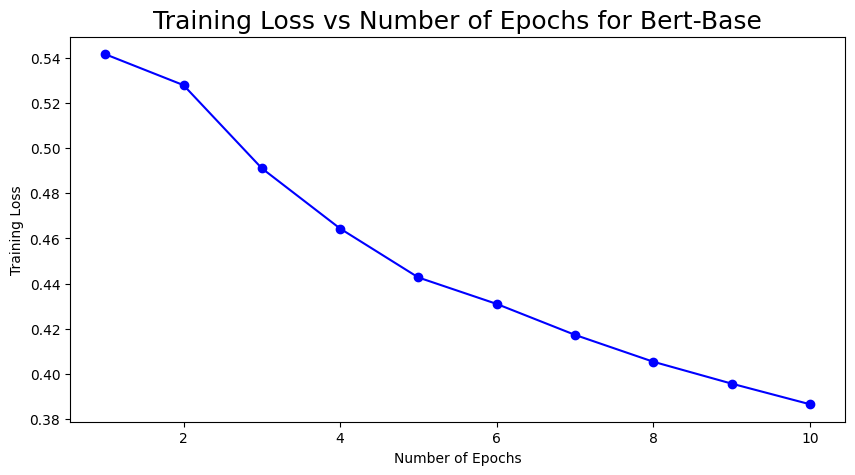

In [39]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

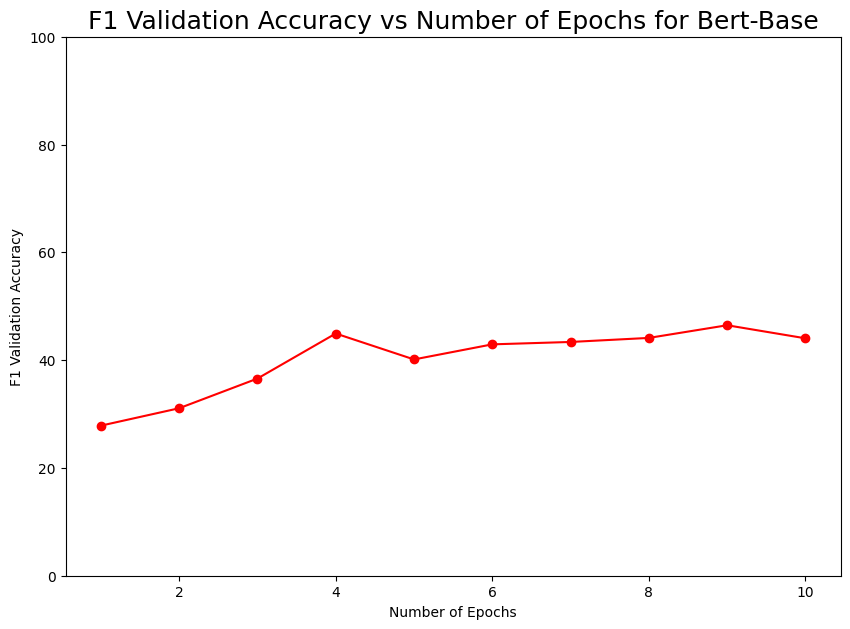

In [40]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

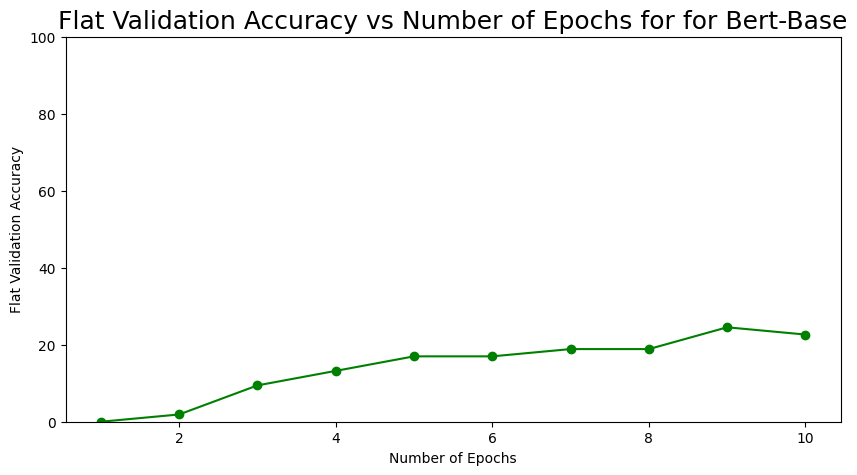

In [41]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [42]:
df_test

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0
3164,6381,সেনা চাই পাকিস্তানকে চুদে দেবে,1,0,1,0,0,0
7238,6111,বাকশালের একাল সেকাল শিরোনামে এপিসোড চাই খালিদ,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1198,504,ডাইনি বুবুজান,1,0,1,0,0,0
3845,2798,কারে চুইদা মাতাল হইছেআরে বোকাচুদি ঢাবির ভিপিরে...,1,1,0,0,0,0
2205,8931,প্রথম বাংলা সিনেমা গিয়ে ইচ্ছা,0,0,0,0,0,0
9008,6217,রব্বানী সময়ে সারা বি এনপি আওয়ামীলীগ মিলেও পারেনি,1,0,1,1,0,0


In [43]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(10)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1]"
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3164,6381,সেনা চাই পাকিস্তানকে চুদে দেবে,1,0,1,0,0,0,"[1, 0, 1, 0, 0, 0]"
7238,6111,বাকশালের একাল সেকাল শিরোনামে এপিসোড চাই খালিদ,1,1,0,0,1,0,"[1, 1, 0, 0, 1, 0]"
4258,5925,সন্দেহ খুনে মিন্নি অবশ্যই জড়িত রিমান্ডে নিলেই ...,1,0,1,0,0,0,"[1, 0, 1, 0, 0, 0]"
4772,9598,ঘর পরিস্কার,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
6479,10296,নতুন পরিচালকের নতুন প্রচেষ্টা উড়নচন্ডী মুক্তি...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
6221,10148,দুই মিনিট ঘন্টা হত🤣🤣🤣🤣,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2735,1013,পুলিশি রাষ্ট্রে সর্ব সাধারণ জনগন আমারা মুক্তি চাই,1,0,1,0,1,0,"[1, 0, 1, 0, 1, 0]"


In [44]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.Text.values)
test_mesh_categories = list(df_test.columns[2:8])

In [45]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [46]:
# Make tensors out of data
test_inputs = torch.IntTensor(test_input_ids)
test_labels = torch.IntTensor(test_labels)
test_masks = torch.IntTensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

**Model-1 Evaluating the model** 

In [47]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 7.56 s, sys: 10.9 ms, total: 7.57 s
Wall time: 7.62 s


**model-1 Classification Report**


In [48]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='weighted')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )


df_test_result=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.5227652718743748
              precision    recall  f1-score   support

     hostile       0.88      0.90      0.89       766
   offensive       0.71      0.42      0.53       360
 Hate speech       0.42      0.53      0.47       246
      threat       0.50      0.08      0.14       133
  defamation       0.55      0.03      0.05       226
     sarcasm       0.60      0.03      0.05       238

   micro avg       0.74      0.50      0.60      1969
   macro avg       0.61      0.33      0.35      1969
weighted avg       0.69      0.50      0.52      1969
 samples avg       0.55      0.37      0.43      1969



In [49]:
model1_f1=Test_F1_Accuracy
model1_pred=pred_labels
print(model1_f1)
print(model1_pred)

0.5227652718743748
[array([0.60151947, 0.11406934, 0.08640264, 0.0481553 , 0.09665556,
       0.27157968], dtype=float32), array([0.94771755, 0.06408236, 0.68691057, 0.07796237, 0.33900315,
       0.25728735], dtype=float32), array([0.12503283, 0.04754806, 0.06746753, 0.01749874, 0.05402819,
       0.06250457], dtype=float32), array([0.939976  , 0.05735413, 0.67010677, 0.14307168, 0.23608935,
       0.26918912], dtype=float32), array([0.8494027 , 0.19656241, 0.19162965, 0.03459547, 0.18550181,
       0.31395644], dtype=float32), array([0.6926307 , 0.26867524, 0.3693361 , 0.1070399 , 0.17454733,
       0.15804443], dtype=float32), array([0.6094056 , 0.16214243, 0.09815355, 0.09999809, 0.10100871,
       0.22418414], dtype=float32), array([0.6180741 , 0.09281869, 0.31218448, 0.01899579, 0.15529929,
       0.31742516], dtype=float32), array([0.8776132 , 0.31327158, 0.25920478, 0.17262197, 0.17286639,
       0.2096625 ], dtype=float32), array([0.9880299 , 0.17992978, 0.7737505 , 0.1345906 

In [50]:
df_report.to_csv('Classification_Report.csv',index=False)

In [51]:
model.save_pretrained('./Multi_label_Classification_Save/')
tokenizer.save_pretrained('./Multi_label_Classification_Save/')

('./Multi_label_Classification_Save/tokenizer_config.json',
 './Multi_label_Classification_Save/special_tokens_map.json',
 './Multi_label_Classification_Save/vocab.txt',
 './Multi_label_Classification_Save/added_tokens.json',
 './Multi_label_Classification_Save/tokenizer.json')

<a id="4"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model 2</p>
#### [Top ↑](#top)

<a id="4"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model-2 Tokenizations</p>
#### [Top ↑](#top)

In [52]:
%%time
from transformers import AutoTokenizer
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
model_name = 'bert-base-multilingual-cased'
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 1.68 s, sys: 141 ms, total: 1.82 s
Wall time: 2.01 s


In [53]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq)

[0 0 0 0 0 0]    2747
[1 1 0 0 0 0]     875
[1 0 1 0 0 0]     815
[1 0 0 0 0 1]     784
[1 1 0 0 1 0]     623
[1 1 0 1 0 0]     577
[1 0 1 0 1 0]     515
[1 1 0 0 0 1]     417
[1 0 0 0 1 0]     353
[1 0 0 1 0 0]     347
[1 0 1 0 0 1]     250
[1 1 1 0 0 0]     215
[1 0 0 0 1 1]     150
[1 0 1 1 0 0]     145
[1 1 1 0 1 0]     137
[1 1 0 0 1 1]     126
[1 0 1 0 1 1]      96
[1 1 1 1 0 0]      60
[1 1 0 1 1 0]      53
[1 1 0 1 0 1]      39
[1 0 0 0 0 0]      35
[1 0 0 1 1 0]      25
[1 0 0 1 0 1]      21
[1 0 1 1 1 0]      19
[1 1 1 0 0 1]      16
[1 1 1 0 1 1]      15
[1 1 1 1 1 0]      12
[1 0 1 1 0 1]       7
[1 1 0 1 1 1]       3
[1 0 0 1 1 1]       2
[1 1 1 1 0 1]       2
Name: one_hot_labels, dtype: int64
df label indices with only one instance:  Index([], dtype='object')


In [54]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.IntTensor(train_inputs)
train_labels = torch.IntTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.IntTensor(validation_inputs)
validation_labels = torch.IntTensor(validation_labels)
validation_masks = torch.IntTensor(validation_masks)
print(train_inputs.shape)
print(train_labels.shape)
print(train_masks.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
print(validation_masks.shape)

torch.Size([7584, 128])
torch.Size([7584, 6])
torch.Size([7584, 128])
torch.Size([1897, 128])
torch.Size([1897, 6])
torch.Size([1897, 128])


<a id="5"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model-2 Creating the Data Loaders</p>
#### [Top ↑](#top)

In [55]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [56]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

<a id="6"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model-2 Loading the pretrained model</p>
#### [Top ↑](#top)

In [57]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model Pushed to Cuda for Training
CPU times: user 2.51 s, sys: 1.7 s, total: 4.22 s
Wall time: 11.4 s


In [58]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [59]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [60]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

<a id="7"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Model-2 Training the model</p>
#### [Top ↑](#top)

In [61]:
wandb.init(project='project_name', entity='fstamim9')
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 8

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='weighted')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.5315400274360881


Epoch :  12%|█▎        | 1/8 [02:45<19:19, 165.67s/it]

F1 Validation Accuracy:  44.02209812045877
Flat Validation Accuracy:  24.390243902439025


Train loss: 0.4477728883258435


Epoch :  25%|██▌       | 2/8 [05:30<16:31, 165.18s/it]

F1 Validation Accuracy:  54.752684386551664
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.41843117535615165


Epoch :  38%|███▊      | 3/8 [08:15<13:45, 165.08s/it]

F1 Validation Accuracy:  53.99900645802285
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.39728307648867117


Epoch :  50%|█████     | 4/8 [11:00<11:00, 165.02s/it]

F1 Validation Accuracy:  52.59156127934409
Flat Validation Accuracy:  29.268292682926827


Train loss: 0.38221341672063874


Epoch :  62%|██████▎   | 5/8 [13:45<08:15, 165.02s/it]

F1 Validation Accuracy:  52.240802675585286
Flat Validation Accuracy:  26.82926829268293


Train loss: 0.37071717461618053


Epoch :  75%|███████▌  | 6/8 [16:30<05:30, 165.00s/it]

F1 Validation Accuracy:  58.49628695530335
Flat Validation Accuracy:  34.146341463414636


Train loss: 0.3572002789553474


Epoch :  88%|████████▊ | 7/8 [19:15<02:44, 164.94s/it]

F1 Validation Accuracy:  59.78537695027569
Flat Validation Accuracy:  36.58536585365854


Train loss: 0.3462631567185666


Epoch : 100%|██████████| 8/8 [22:00<00:00, 165.01s/it]

F1 Validation Accuracy:  57.83450429352068
Flat Validation Accuracy:  26.82926829268293




train_loss,█▅▄▃▂▂▁▁
val_f1_accuracy,▁▆▅▅▅▇█▇
val_flat_accuracy,▁▅▅▄▂▇█▂
train_loss,0.34626
val_f1_accuracy,57.8345
val_flat_accuracy,26.82927


In [62]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

<a id="8"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model-2 Visualizing The results</p>

#### [Top ↑](#top)

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

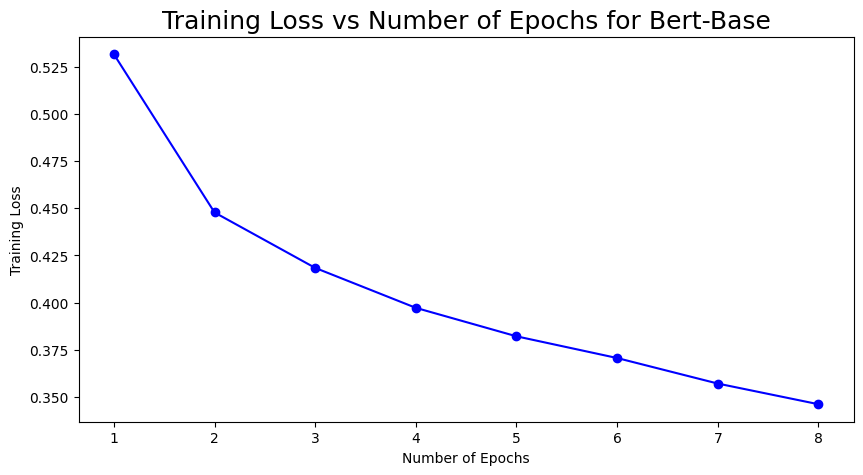

In [63]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

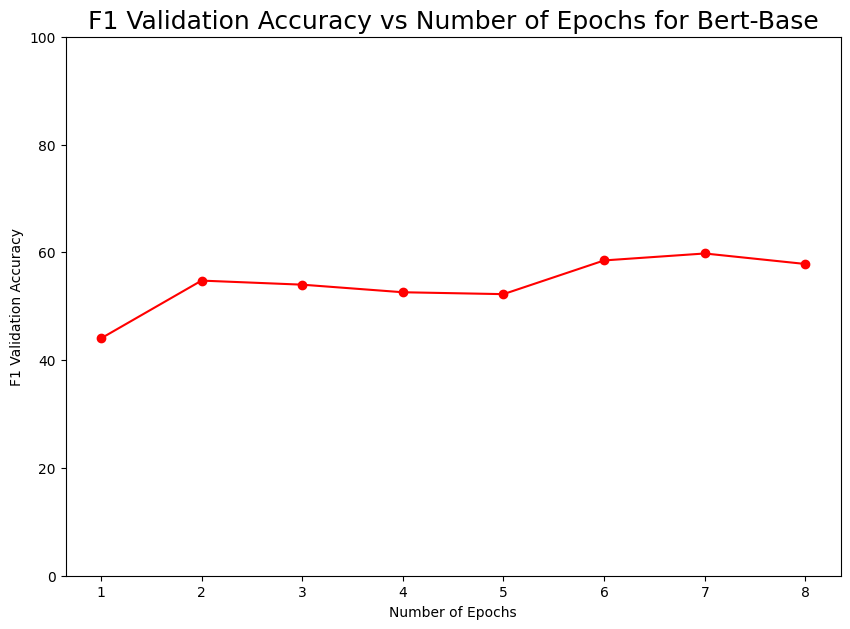

In [64]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

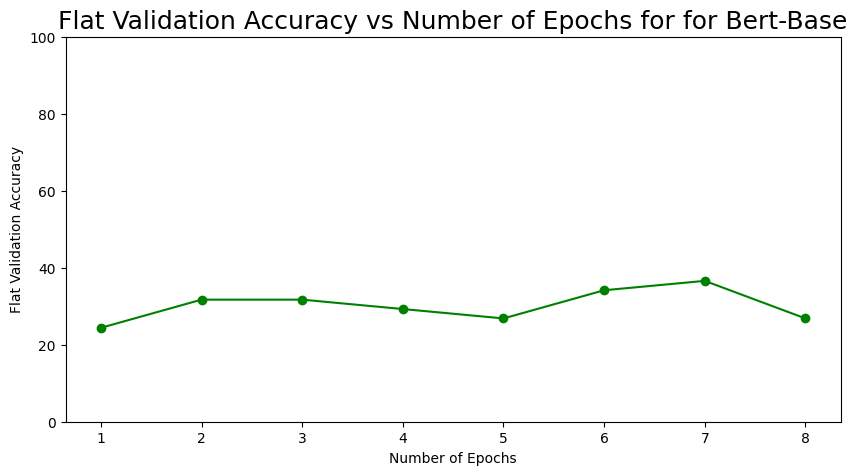

In [65]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [66]:

df_test

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1]"
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3164,6381,সেনা চাই পাকিস্তানকে চুদে দেবে,1,0,1,0,0,0,"[1, 0, 1, 0, 0, 0]"
7238,6111,বাকশালের একাল সেকাল শিরোনামে এপিসোড চাই খালিদ,1,1,0,0,1,0,"[1, 1, 0, 0, 1, 0]"
...,...,...,...,...,...,...,...,...,...
1198,504,ডাইনি বুবুজান,1,0,1,0,0,0,"[1, 0, 1, 0, 0, 0]"
3845,2798,কারে চুইদা মাতাল হইছেআরে বোকাচুদি ঢাবির ভিপিরে...,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
2205,8931,প্রথম বাংলা সিনেমা গিয়ে ইচ্ছা,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
9008,6217,রব্বানী সময়ে সারা বি এনপি আওয়ামীলীগ মিলেও পারেনি,1,0,1,1,0,0,"[1, 0, 1, 1, 0, 0]"


In [67]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1]"
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [68]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.Text.values)
test_mesh_categories = list(df_test.columns[2:8])

In [69]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [70]:
# Make tensors out of data
test_inputs = torch.IntTensor(test_input_ids)
test_labels = torch.IntTensor(test_labels)
test_masks = torch.IntTensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

<a id="9"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Model-2 Evaluating the model</p>
#### [Top ↑](#top) 

In [71]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    
# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 7.6 s, sys: 9.99 ms, total: 7.61 s
Wall time: 7.59 s


<a id="10"></a>
## <p style="background-color:#1a0a36;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Model-2  Classification Report</p>
#### [Top ↑](#top)


In [72]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='weighted')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )


df_test_result=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()



Test F1 Accuracy:  0.5670389913257583
              precision    recall  f1-score   support

     hostile       0.92      0.95      0.93       766
   offensive       0.81      0.61      0.69       360
 Hate speech       0.56      0.45      0.50       246
      threat       0.39      0.08      0.14       133
  defamation       0.30      0.01      0.03       226
     sarcasm       0.20      0.01      0.02       238

   micro avg       0.82      0.55      0.65      1969
   macro avg       0.53      0.35      0.38      1969
weighted avg       0.66      0.55      0.57      1969
 samples avg       0.62      0.41      0.48      1969



In [73]:
model2_f1=Test_F1_Accuracy
model2_pred=pred_labels


**Model-3**

**Model-3 Tokenizations**

In [74]:
%%time
from transformers import AutoTokenizer
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
model_name = 'sagorsarker/bangla-bert-base'
# model_name='distilbert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 1.39 s, sys: 37 ms, total: 1.42 s
Wall time: 2.12 s


In [75]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq)

[0 0 0 0 0 0]    2747
[1 1 0 0 0 0]     875
[1 0 1 0 0 0]     815
[1 0 0 0 0 1]     784
[1 1 0 0 1 0]     623
[1 1 0 1 0 0]     577
[1 0 1 0 1 0]     515
[1 1 0 0 0 1]     417
[1 0 0 0 1 0]     353
[1 0 0 1 0 0]     347
[1 0 1 0 0 1]     250
[1 1 1 0 0 0]     215
[1 0 0 0 1 1]     150
[1 0 1 1 0 0]     145
[1 1 1 0 1 0]     137
[1 1 0 0 1 1]     126
[1 0 1 0 1 1]      96
[1 1 1 1 0 0]      60
[1 1 0 1 1 0]      53
[1 1 0 1 0 1]      39
[1 0 0 0 0 0]      35
[1 0 0 1 1 0]      25
[1 0 0 1 0 1]      21
[1 0 1 1 1 0]      19
[1 1 1 0 0 1]      16
[1 1 1 0 1 1]      15
[1 1 1 1 1 0]      12
[1 0 1 1 0 1]       7
[1 1 0 1 1 1]       3
[1 0 0 1 1 1]       2
[1 1 1 1 0 1]       2
Name: one_hot_labels, dtype: int64
df label indices with only one instance:  Index([], dtype='object')


In [76]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.IntTensor(train_inputs)
train_labels = torch.IntTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.IntTensor(validation_inputs)
validation_labels = torch.IntTensor(validation_labels)
validation_masks = torch.IntTensor(validation_masks)
print(train_inputs.shape)
print(train_labels.shape)
print(train_masks.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
print(validation_masks.shape)

torch.Size([7584, 128])
torch.Size([7584, 6])
torch.Size([7584, 128])
torch.Size([1897, 128])
torch.Size([1897, 6])
torch.Size([1897, 128])


**Model-3 Creating the Data**

In [77]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [78]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

**Model-3 Loading the pretrained model**

In [79]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model Pushed to Cuda for Training
CPU times: user 2.29 s, sys: 1.36 s, total: 3.66 s
Wall time: 8.65 s


In [80]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [81]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [82]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

**Model-3 Training the model**

In [83]:
wandb.init(project='project_name', entity='fstamim9')
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 8

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='weighted')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.49744061211577983


Epoch :  12%|█▎        | 1/8 [02:44<19:10, 164.32s/it]

F1 Validation Accuracy:  50.837490814866385
Flat Validation Accuracy:  26.82926829268293


Train loss: 0.4114337566019106


Epoch :  25%|██▌       | 2/8 [05:27<16:22, 163.68s/it]

F1 Validation Accuracy:  59.36450301834918
Flat Validation Accuracy:  34.146341463414636


Train loss: 0.3798042270315795


Epoch :  38%|███▊      | 3/8 [08:10<13:37, 163.44s/it]

F1 Validation Accuracy:  58.1795753444741
Flat Validation Accuracy:  29.268292682926827


Train loss: 0.356711029755969


Epoch :  50%|█████     | 4/8 [10:54<10:53, 163.42s/it]

F1 Validation Accuracy:  60.831900011466566
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.33429124099867685


Epoch :  62%|██████▎   | 5/8 [13:37<08:10, 163.49s/it]

F1 Validation Accuracy:  58.507834757834765
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.3145410501155533


Epoch :  75%|███████▌  | 6/8 [16:20<05:26, 163.41s/it]

F1 Validation Accuracy:  58.94073139974779
Flat Validation Accuracy:  29.268292682926827


Train loss: 0.2943862121896583


Epoch :  88%|████████▊ | 7/8 [19:04<02:43, 163.46s/it]

F1 Validation Accuracy:  63.08547554449194
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.27433021541904


Epoch : 100%|██████████| 8/8 [21:48<00:00, 163.51s/it]

F1 Validation Accuracy:  61.919006919006925
Flat Validation Accuracy:  31.70731707317073




train_loss,█▅▄▄▃▂▂▁
val_f1_accuracy,▁▆▅▇▅▆█▇
val_flat_accuracy,▁█▃▆▆▃▆▆
train_loss,0.27433
val_f1_accuracy,61.91901
val_flat_accuracy,31.70732


In [84]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

**Model-3 Visualizing The results**

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

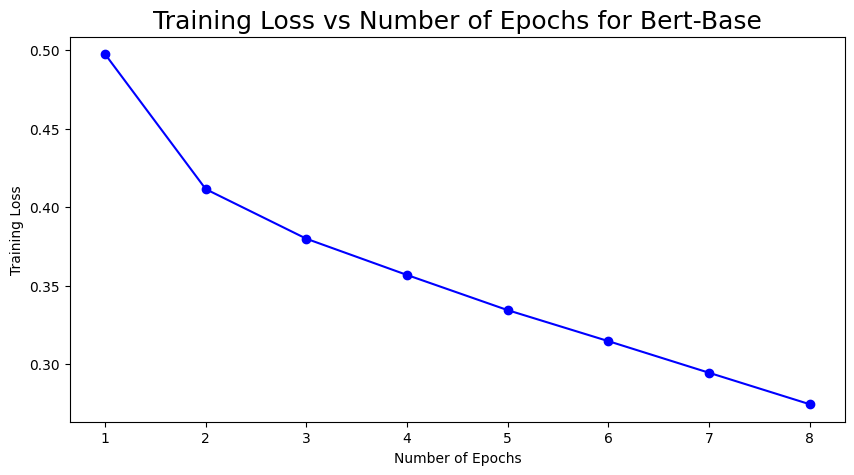

In [85]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

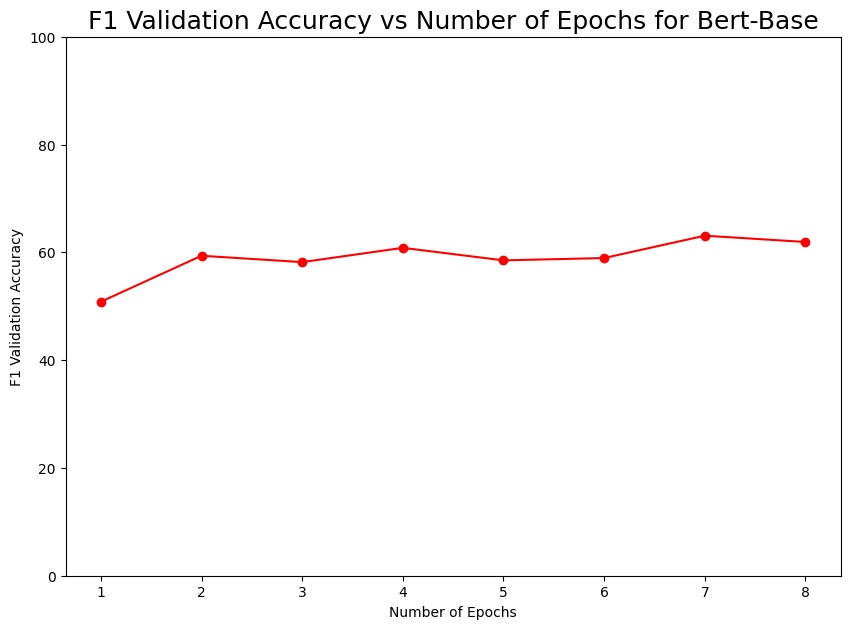

In [86]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

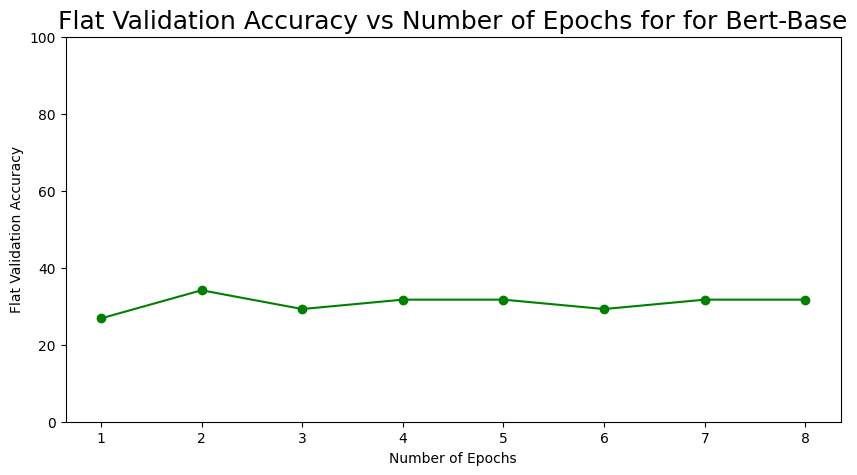

In [87]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [88]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1]"
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [89]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.Text.values)
test_mesh_categories = list(df_test.columns[2:8])

In [90]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [91]:
# Make tensors out of data
test_inputs = torch.IntTensor(test_input_ids)
test_labels = torch.IntTensor(test_labels)
test_masks = torch.IntTensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

**Model-3 Evaluating the model**

In [92]:

%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 7.56 s, sys: 13 ms, total: 7.58 s
Wall time: 7.59 s


**Model-3 Classification Report**

In [93]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='weighted')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )


df_test_result=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.6541299741925015
              precision    recall  f1-score   support

     hostile       0.95      0.92      0.94       766
   offensive       0.73      0.64      0.68       360
 Hate speech       0.56      0.49      0.52       246
      threat       0.53      0.37      0.43       133
  defamation       0.41      0.26      0.32       226
     sarcasm       0.43      0.22      0.29       238

   micro avg       0.75      0.62      0.68      1969
   macro avg       0.60      0.48      0.53      1969
weighted avg       0.71      0.62      0.65      1969
 samples avg       0.54      0.46      0.48      1969



In [94]:
model3_f1=Test_F1_Accuracy
model3_pred=pred_labels

**Model-4**

**Model-4 Tokenizations**

In [95]:
%%time
from transformers import AutoTokenizer
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
model_name = 'xlm-roberta-base'
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks


tokenizer outputs:  dict_keys(['input_ids', 'attention_mask'])
CPU times: user 2.13 s, sys: 71 ms, total: 2.2 s
Wall time: 2.93 s


In [96]:
# df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

# print(df_train.shape)
# print(df_test.shape)
# df_test

In [97]:
df_train['one_hot_labels'] = list(df_train[mesh_Heading_categories].values)
df_train.head(3)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
5731,5513,মরোশ কেনো খানকি,1,1,1,0,0,0,"[1, 1, 1, 0, 0, 0]"
4011,4121,কুক,1,1,0,0,0,1,"[1, 1, 0, 0, 0, 1]"
5920,7872,ভিডিও গুলো দেখি সবচেয়ে অন্যতম সুন্দর ভিডিও ভাল...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [98]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq)

[0 0 0 0 0 0]    2747
[1 1 0 0 0 0]     875
[1 0 1 0 0 0]     815
[1 0 0 0 0 1]     784
[1 1 0 0 1 0]     623
[1 1 0 1 0 0]     577
[1 0 1 0 1 0]     515
[1 1 0 0 0 1]     417
[1 0 0 0 1 0]     353
[1 0 0 1 0 0]     347
[1 0 1 0 0 1]     250
[1 1 1 0 0 0]     215
[1 0 0 0 1 1]     150
[1 0 1 1 0 0]     145
[1 1 1 0 1 0]     137
[1 1 0 0 1 1]     126
[1 0 1 0 1 1]      96
[1 1 1 1 0 0]      60
[1 1 0 1 1 0]      53
[1 1 0 1 0 1]      39
[1 0 0 0 0 0]      35
[1 0 0 1 1 0]      25
[1 0 0 1 0 1]      21
[1 0 1 1 1 0]      19
[1 1 1 0 0 1]      16
[1 1 1 0 1 1]      15
[1 1 1 1 1 0]      12
[1 0 1 1 0 1]       7
[1 1 0 1 1 1]       3
[1 0 0 1 1 1]       2
[1 1 1 1 0 1]       2
Name: one_hot_labels, dtype: int64
df label indices with only one instance:  Index([], dtype='object')


In [99]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.20)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.IntTensor(train_inputs)
train_labels = torch.IntTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.IntTensor(validation_inputs)
validation_labels = torch.IntTensor(validation_labels)
validation_masks = torch.IntTensor(validation_masks)
print(train_inputs.shape)
print(train_labels.shape)
print(train_masks.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
print(validation_masks.shape)

torch.Size([7584, 128])
torch.Size([7584, 6])
torch.Size([7584, 128])
torch.Size([1897, 128])
torch.Size([1897, 6])
torch.Size([1897, 128])


**Model-4 Creating the Data Loaders**

In [100]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [101]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

**Model-4 Loading the pretrained model**

In [102]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('model_name', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.1.attention.output.dense.bias', 'roberta.encoder.layer.11.attention.self.key.weight', 'roberta.encoder.layer.4.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.dense.bias', 'roberta.encoder.layer.10.output.LayerNorm.bias', 'roberta.encoder.layer.4.attention.output.dense.weight', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.7.attention.self.key.weight', 'roberta.encoder.layer.9.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.dense.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.embeddings.LayerNorm.weight', 'roberta.encoder.layer.7.output.dense.weight', 'roberta.encoder.layer.10.attention.output.dense.bias', 'roberta.encoder.layer.2.attention.self.value.weight', 'roberta.encoder.layer.0.attention.self.query.bias', 'roberta.encoder.layer.2.intermediate.dense.weight

Model Pushed to Cuda for Training
CPU times: user 7.15 s, sys: 2.42 s, total: 9.58 s
Wall time: 22.4 s


In [103]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [104]:
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)
# optimizer = AdamW(model.parameters(),lr=4e-5)  # Default optimization #XL-NET

In [105]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

**Model-4 Training the model**

In [106]:
wandb.init(project='project_name', entity='fstamim9')
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 8

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)

    ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='weighted')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.5436474360337779


Epoch :  12%|█▎        | 1/8 [02:50<19:53, 170.47s/it]

F1 Validation Accuracy:  30.805860805860807
Flat Validation Accuracy:  0.0


Train loss: 0.48990735336512076


Epoch :  25%|██▌       | 2/8 [05:40<17:00, 170.10s/it]

F1 Validation Accuracy:  45.03722084367246
Flat Validation Accuracy:  24.390243902439025


Train loss: 0.45006152336336985


Epoch :  38%|███▊      | 3/8 [08:30<14:09, 170.00s/it]

F1 Validation Accuracy:  47.02564102564102
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.42953817634021535


Epoch :  50%|█████     | 4/8 [11:20<11:19, 169.93s/it]

F1 Validation Accuracy:  46.54403567447045
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.4113365772391568


Epoch :  62%|██████▎   | 5/8 [14:09<08:29, 169.93s/it]

F1 Validation Accuracy:  59.11940497913349
Flat Validation Accuracy:  34.146341463414636


Train loss: 0.4075791352436322


Epoch :  75%|███████▌  | 6/8 [16:59<05:39, 169.93s/it]

F1 Validation Accuracy:  53.3816425120773
Flat Validation Accuracy:  31.70731707317073


Train loss: 0.3913761993416217


Epoch :  88%|████████▊ | 7/8 [19:49<02:49, 169.91s/it]

F1 Validation Accuracy:  61.04039087089935
Flat Validation Accuracy:  36.58536585365854


Train loss: 0.3857895018172865


Epoch : 100%|██████████| 8/8 [22:39<00:00, 169.96s/it]

F1 Validation Accuracy:  58.32500832500832
Flat Validation Accuracy:  39.02439024390244




train_loss,█▆▄▃▂▂▁▁
val_f1_accuracy,▁▄▅▅█▆█▇
val_flat_accuracy,▁▅▇▇▇▇██
train_loss,0.38579
val_f1_accuracy,58.32501
val_flat_accuracy,39.02439


In [107]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

**Model-4 Visualizing The results**

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

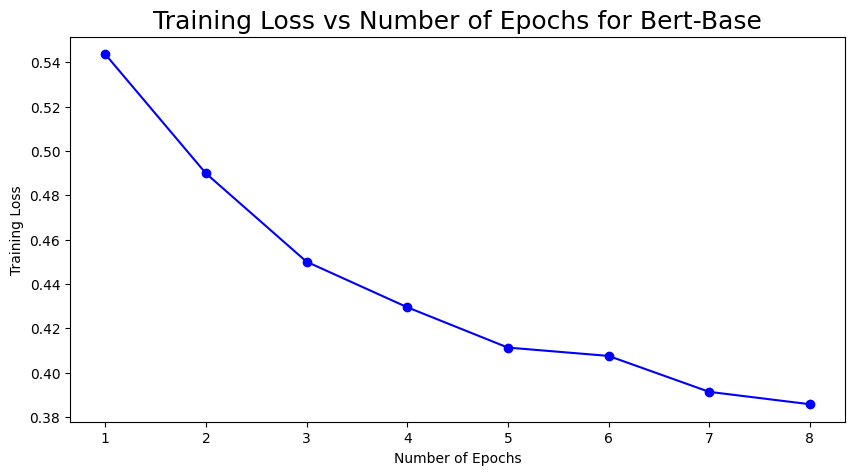

In [108]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

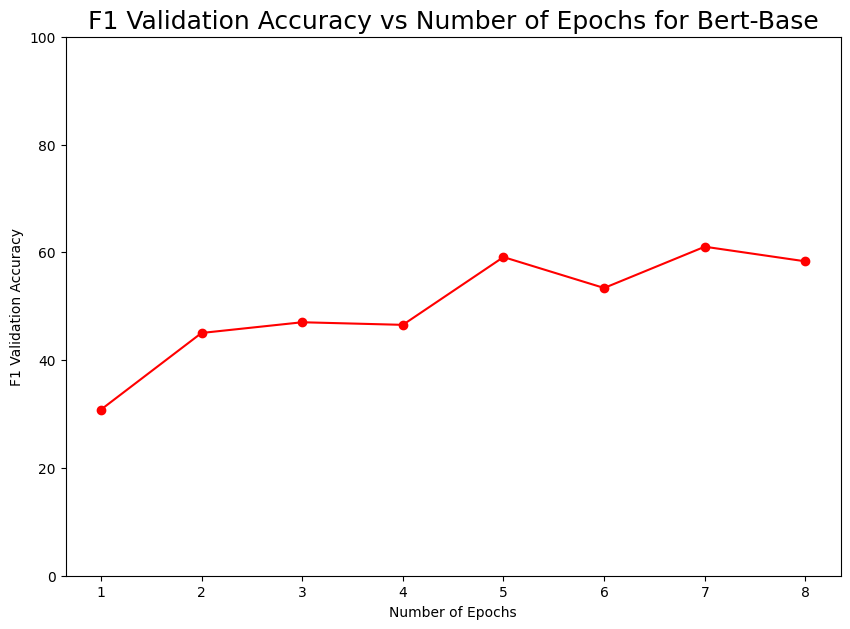

In [109]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

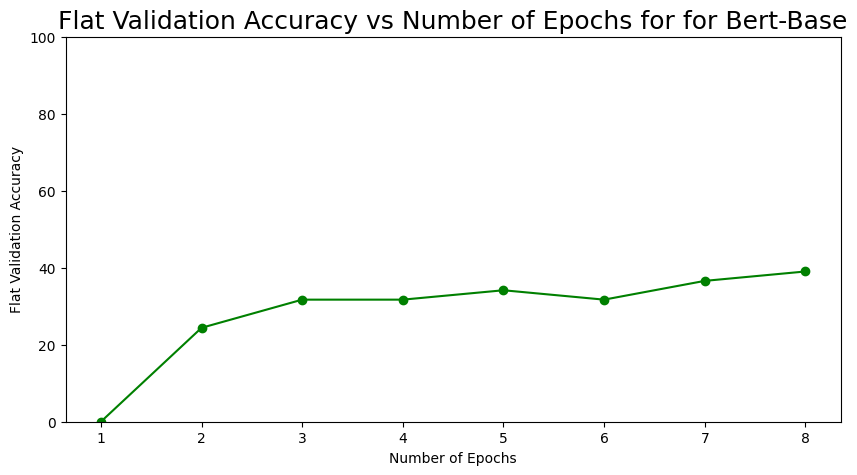

In [110]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [111]:
# df_train, df_test = train_test_split(df, random_state=32, test_size=0.20, shuffle=True)

# print(df_train.shape)
# print(df_test.shape)
# df_test

In [112]:
# df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
# df_test.head(3)

In [113]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.Text.values)
test_mesh_categories = list(df_test.columns[2:8])

In [114]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [115]:
# Make tensors out of data
test_inputs = torch.IntTensor(test_input_ids)
test_labels = torch.IntTensor(test_labels)
test_masks = torch.IntTensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

**Model-4 Evaluating the model**

In [116]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 7.64 s, sys: 7.99 ms, total: 7.65 s
Wall time: 7.68 s


**Model-4 Classification Report**

In [117]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='weighted')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )


df_test_result=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()


Test F1 Accuracy:  0.5485099162953293
              precision    recall  f1-score   support

     hostile       0.92      0.93      0.93       766
   offensive       0.81      0.49      0.61       360
 Hate speech       0.45      0.52      0.48       246
      threat       0.50      0.03      0.06       133
  defamation       0.69      0.05      0.09       226
     sarcasm       0.40      0.01      0.02       238

   micro avg       0.79      0.53      0.63      1969
   macro avg       0.63      0.34      0.36      1969
weighted avg       0.72      0.53      0.55      1969
 samples avg       0.59      0.39      0.45      1969



In [118]:
model4_f1=Test_F1_Accuracy
model4_pred=pred_labels
print(model4_f1)
print(type(model4_pred))

0.5485099162953293
<class 'list'>


> **Model 5**


In [119]:
%%time
from transformers import AutoTokenizer
max_length = 128
#tokenizer = RobertaTokenizer.from_pretrained('distilroberta-base', do_lower_case=False)  # tokenizer
model_name = 'csebuetnlp/banglabert'
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2', do_lower_case=True) 
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
#tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

encodings = tokenizer.batch_encode_plus(Article_train,max_length=max_length,padding=True,truncation=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

input_ids = encodings['input_ids'] # tokenized and encoded sentences
attention_masks = encodings['attention_mask'] # attention masks

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 1.39 s, sys: 13 ms, total: 1.4 s
Wall time: 2.02 s


In [120]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow me to stratify split our training data later
label_counts = df_train.one_hot_labels.astype(str).value_counts()
print(label_counts)
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df_train[df_train.one_hot_labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq)

[0 0 0 0 0 0]    2747
[1 1 0 0 0 0]     875
[1 0 1 0 0 0]     815
[1 0 0 0 0 1]     784
[1 1 0 0 1 0]     623
[1 1 0 1 0 0]     577
[1 0 1 0 1 0]     515
[1 1 0 0 0 1]     417
[1 0 0 0 1 0]     353
[1 0 0 1 0 0]     347
[1 0 1 0 0 1]     250
[1 1 1 0 0 0]     215
[1 0 0 0 1 1]     150
[1 0 1 1 0 0]     145
[1 1 1 0 1 0]     137
[1 1 0 0 1 1]     126
[1 0 1 0 1 1]      96
[1 1 1 1 0 0]      60
[1 1 0 1 1 0]      53
[1 1 0 1 0 1]      39
[1 0 0 0 0 0]      35
[1 0 0 1 1 0]      25
[1 0 0 1 0 1]      21
[1 0 1 1 1 0]      19
[1 1 1 0 0 1]      16
[1 1 1 0 1 1]      15
[1 1 1 1 1 0]      12
[1 0 1 1 0 1]       7
[1 1 0 1 1 1]       3
[1 0 0 1 1 1]       2
[1 1 1 1 0 1]       2
Name: one_hot_labels, dtype: int64
df label indices with only one instance:  Index([], dtype='object')


In [121]:
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=2020, test_size=0.10)

# Convert all of our data into torch tensors, the required datatype for our BERT Pytorch model
train_inputs = torch.IntTensor(train_inputs)
train_labels = torch.IntTensor(train_labels)
train_masks = torch.LongTensor(train_masks)

validation_inputs = torch.IntTensor(validation_inputs)
validation_labels = torch.IntTensor(validation_labels)
validation_masks = torch.IntTensor(validation_masks)
print(train_inputs.shape)
print(train_labels.shape)
print(train_masks.shape)

print(validation_inputs.shape)
print(validation_labels.shape)
print(validation_masks.shape)

torch.Size([8532, 128])
torch.Size([8532, 6])
torch.Size([8532, 128])
torch.Size([949, 128])
torch.Size([949, 6])
torch.Size([949, 128])


In [122]:
batch_size = 64

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data =     TensorDataset(train_inputs, train_masks, train_labels,)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [123]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

In [124]:
%%time
#Tried Several Models Locally XLNet was performing Best. Note If you are changing the model then change the Tokenizer also
# model = RobertaForSequenceClassification.from_pretrained('distilroberta-base', num_labels=num_labels)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_labels)
model.cuda()
print('Model Pushed to Cuda for Training')

You are using a model of type electra to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at csebuetnlp/banglabert were not used when initializing BertForSequenceClassification: ['electra.encoder.layer.2.attention.self.value.weight', 'electra.encoder.layer.9.output.LayerNorm.bias', 'electra.encoder.layer.9.attention.output.dense.bias', 'electra.encoder.layer.6.output.LayerNorm.weight', 'electra.encoder.layer.9.attention.self.query.weight', 'electra.encoder.layer.4.output.dense.bias', 'electra.encoder.layer.1.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.9.intermediate.dense.weight', 'electra.encoder.layer.8.attention.self.query.weight', 'electra.encoder.layer.1.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.5.attention.self.value.bias', 'electra.encoder.layer.11.output.dense.bias', 'electra.encoder.layer.0.intermediate.dense.bias', 'electra.encoder.layer.8.attention.output.LayerNorm.weight', 'electra.encoder.layer.1.attention.se

Model Pushed to Cuda for Training
CPU times: user 2.31 s, sys: 681 ms, total: 2.99 s
Wall time: 8.2 s


In [164]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters,lr=6e-6)

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH']='true'

In [165]:
wandb.init(project='project_name', entity='fstamim9')
# For Storing our loss and accuracy for plotting
train_loss_set = []
val_f1_accuracy_list,val_flat_accuracy_list,training_loss_list,epochs_list=[],[],[],[]

# Number of training epochs (Orignal author's recommend between 10 and 20)
epochs = 8

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch "):
    # Training

    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels= batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()

        # Forward pass for multilabel classification
        # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss
        # Creates a criterion that measures the Binary Cross Entropy between the target and the input probabilities
        # Also This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable 
        # than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the 
        # log-sum-exp trick for numerical stability.
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        loss_func = BCEWithLogitsLoss() 
        loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
        
        train_loss_set.append(loss.item())    

        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # scheduler.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    training_loss_list.append(tr_loss/nb_tr_steps)
      ###############################################################################

    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Variables to gather full output
    logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

    # Predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            # Forward pass
            outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            b_logit_pred = outs[0]
            pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

    # Flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]

    # Calculate Accuracy
    threshold = 0.50
    pred_bools = [pl>threshold for pl in pred_labels]
    true_bools = [tl==1 for tl in true_labels]
    val_f1_accuracy = f1_score(true_bools,pred_bools,average='weighted')*100
    val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

    print('F1 Validation Accuracy: ', val_f1_accuracy)  
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    print('\n')
    val_f1_accuracy_list.append(val_f1_accuracy)
    val_flat_accuracy_list.append(val_flat_accuracy)
    epochs_list.append(epochs)  
    
    wandb.log({"train_loss":tr_loss/nb_tr_steps,"val_f1_accuracy":val_f1_accuracy,"val_flat_accuracy":val_flat_accuracy,})
wandb.finish()

Epoch :   0%|          | 0/8 [00:00<?, ?it/s]

Train loss: 0.25951733606964794


Epoch :  12%|█▎        | 1/8 [02:54<20:18, 174.13s/it]

F1 Validation Accuracy:  60.46872006817659
Flat Validation Accuracy:  39.62264150943396


Train loss: 0.251121708595041


Epoch :  25%|██▌       | 2/8 [05:47<17:22, 173.68s/it]

F1 Validation Accuracy:  66.33253968253969
Flat Validation Accuracy:  41.509433962264154


Train loss: 0.24182354603240738


Epoch :  38%|███▊      | 3/8 [08:41<14:28, 173.67s/it]

F1 Validation Accuracy:  65.87527777777778
Flat Validation Accuracy:  39.62264150943396


Train loss: 0.23536186420650623


Epoch :  50%|█████     | 4/8 [11:34<11:33, 173.46s/it]

F1 Validation Accuracy:  62.8911288036288
Flat Validation Accuracy:  39.62264150943396


Train loss: 0.2290801412578839


Epoch :  62%|██████▎   | 5/8 [14:27<08:40, 173.35s/it]

F1 Validation Accuracy:  60.991128803628804
Flat Validation Accuracy:  39.62264150943396


Train loss: 0.21727871505626992


Epoch :  75%|███████▌  | 6/8 [17:20<05:46, 173.33s/it]

F1 Validation Accuracy:  64.29194444444445
Flat Validation Accuracy:  39.62264150943396


Train loss: 0.2083287266875381


Epoch :  88%|████████▊ | 7/8 [20:14<02:53, 173.34s/it]

F1 Validation Accuracy:  65.57631257631257
Flat Validation Accuracy:  37.735849056603776


Train loss: 0.20082693991821204


Epoch : 100%|██████████| 8/8 [23:07<00:00, 173.45s/it]

F1 Validation Accuracy:  66.76228799739074
Flat Validation Accuracy:  43.39622641509434




train_loss,█▇▆▅▄▃▂▁
val_f1_accuracy,▁█▇▄▂▅▇█
val_flat_accuracy,▃▆▃▃▃▃▁█
train_loss,0.20083
val_f1_accuracy,66.76229
val_flat_accuracy,43.39623


In [166]:
num_epochs = np.arange(1,len(training_loss_list)+1)
df_train_results=pd.DataFrame({'Epochs':num_epochs,'F1 Validation Accuracy':val_f1_accuracy_list,\
                               'Flat Validation Accuracy':val_flat_accuracy_list,'Train loss':training_loss_list})

Text(0.5, 1.0, 'Training Loss vs Number of Epochs for Bert-Base')

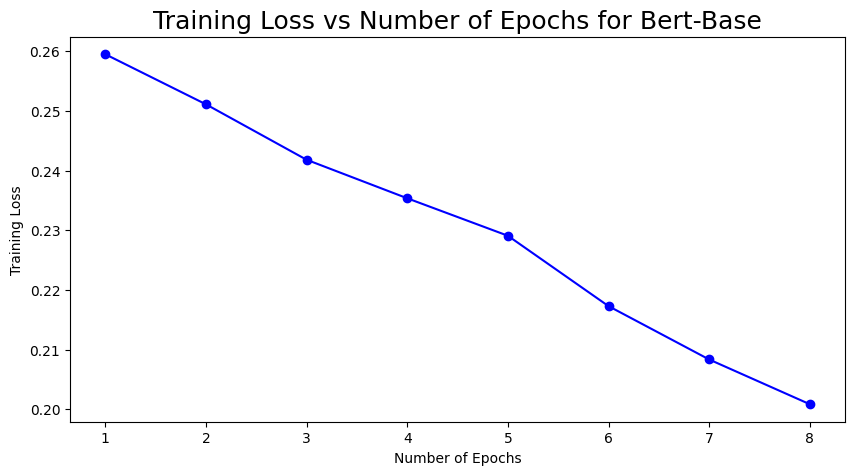

In [167]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(training_loss_list) ,'bo-',label="Train Loss")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Training Loss")
ax.set_title("Training Loss vs Number of Epochs for Bert-Base",fontsize=18)

(0.0, 100.0)

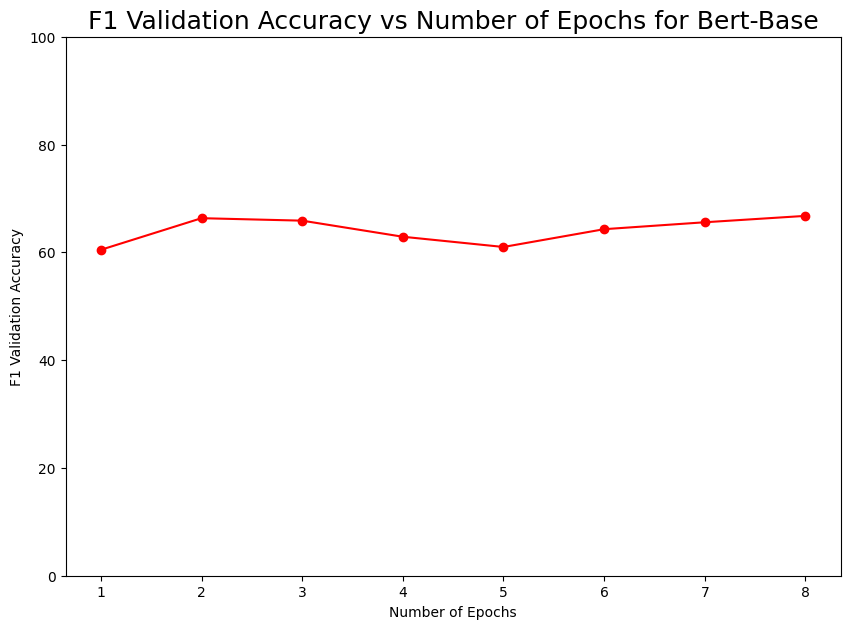

In [168]:
fig, ax = plt.subplots(figsize=(10, 7));
ax.plot(num_epochs, np.array(val_f1_accuracy_list),'ro-' ,label="F1 Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("F1 Validation Accuracy")
ax.set_title("F1 Validation Accuracy vs Number of Epochs for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

(0.0, 100.0)

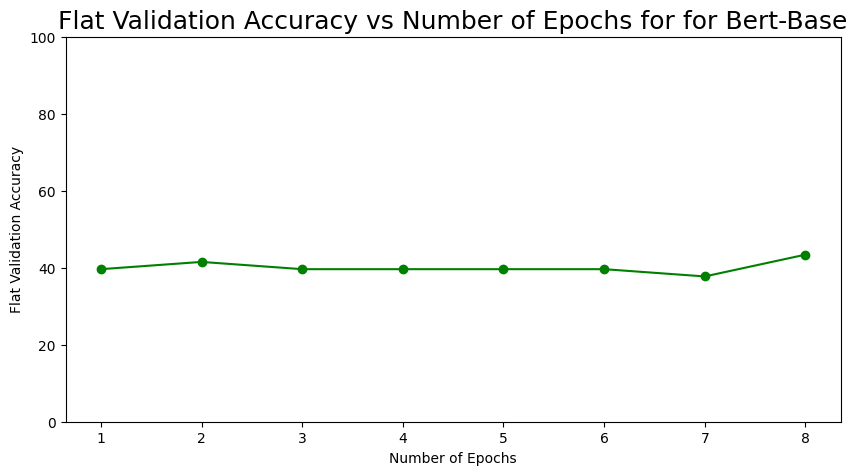

In [169]:
fig, ax = plt.subplots(figsize=(10, 5));
ax.plot(num_epochs, np.array(val_flat_accuracy_list),'go-', label="Flat Validation Accuracy")
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Flat Validation Accuracy")
ax.set_title("Flat Validation Accuracy vs Number of Epochs for for Bert-Base",fontsize=18)
ax.set_ylim(0, 100)

In [170]:
df_test['one_hot_labels'] = list(df_test[mesh_Heading_categories].values)
df_test.head(3)

,id,Text,hostile,offensive,Hate speech,threat,defamation,sarcasm,one_hot_labels
4327,755,খাটে ঘুমানোর সময় মজা দুই জনই পাইছে,1,1,0,0,0,0,"[1, 1, 0, 0, 0, 0]"
10478,6795,হুম পৃথিবীতে এখনো ধর্ষন তোর ভারতেই ধর্মবিরো...,1,0,0,0,0,1,"[1, 0, 0, 0, 0, 1]"
1591,8018,আলহামদুলিল্লাহ আললাহ একমাত্র বাচানের মালিক সুস...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [171]:
test_labels = list(df_test.one_hot_labels.values)
Articles_test = list(df_test.Text.values)
test_mesh_categories = list(df_test.columns[2:8])

In [172]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(Articles_test,max_length=max_length,padding=True,truncation=True)
test_input_ids = test_encodings['input_ids']
test_attention_masks = test_encodings['attention_mask']

In [173]:
# Make tensors out of data
test_inputs = torch.IntTensor(test_input_ids)
test_labels = torch.IntTensor(test_labels)
test_masks = torch.IntTensor(test_attention_masks)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels,)# test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

In [174]:
%%time

# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, = batch
    with torch.no_grad():
        # Forward pass
        outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        b_logit_pred = outs[0]
        pred_label = torch.sigmoid(b_logit_pred)

        b_logit_pred = b_logit_pred.detach().cpu().numpy()
        pred_label = pred_label.to('cpu').numpy()
        b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

CPU times: user 7.27 s, sys: 24.9 ms, total: 7.3 s
Wall time: 7.77 s


In [175]:
pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding
# Print and save classification report
Test_F1_Accuracy=f1_score(true_bools, pred_bools,average='weighted')
Test_Flat_Accuracy= accuracy_score(true_bools, pred_bools)
print('Test F1 Accuracy: ',Test_F1_Accuracy )


df_test_result=pd.DataFrame({'Test F1 Accuracy':Test_F1_Accuracy, 'Test Flat Accuracy':Test_Flat_Accuracy},index=[0])

print(classification_report(true_bools,pred_bools,target_names=test_mesh_categories))
clf_report = classification_report(true_bools,pred_bools,target_names=test_mesh_categories,output_dict=True)
df_report=pd.DataFrame(clf_report).transpose()

Test F1 Accuracy:  0.6367090072293908
              precision    recall  f1-score   support

     hostile       0.93      0.92      0.93       766
   offensive       0.72      0.64      0.68       360
 Hate speech       0.51      0.37      0.43       246
      threat       0.47      0.35      0.40       133
  defamation       0.33      0.29      0.31       226
     sarcasm       0.34      0.27      0.30       238

   micro avg       0.69      0.61      0.65      1969
   macro avg       0.55      0.48      0.51      1969
weighted avg       0.67      0.61      0.64      1969
 samples avg       0.51      0.45      0.46      1969



In [176]:
model5_f1=Test_F1_Accuracy
model5_pred=pred_labels

**Ensemble of Trnasformer**

**weighted Ensemble**

In [177]:
import itertools
import numpy as np
from sklearn.metrics import classification_report, f1_score

def ensemble_predictions(preds_list, f1_scores, threshold=0.3):
    """
    Generate all possible combinations of model predictions and calculate the
    weighted ensemble predictions and F1 score for each combination.
    
    Args:
        preds_list (list of numpy arrays): List of predicted probabilities for each model.
        f1_scores (list of floats): List of F1 scores for each model.
        threshold (float): Threshold value for binary classification.
    
    Returns:
        A dictionary containing the weighted ensemble predictions and F1 score for
        each combination of model predictions.
    """
    n_models = len(preds_list)
    model_combinations = []
    for i in range(1, n_models+1):
        combinations = itertools.combinations(range(n_models), i)
        model_combinations += [list(c) for c in combinations]
    
    ensemble_results = {}
    for combination in model_combinations:
        combination_preds = [preds_list[i] for i in combination]
        combination_f1_scores = [f1_scores[i] for i in combination]
        weights = [f1 / sum(combination_f1_scores) for f1 in combination_f1_scores]
        weighted_pred_probs = np.average(combination_preds, axis=0, weights=weights)
        pred_bools = weighted_pred_probs > threshold
        weighted_f1_score = f1_score(true_bools, pred_bools, average='weighted')
        ensemble_results[str(combination)] = {'pred_bools': pred_bools,
                                               'weighted_f1_score': weighted_f1_score}
    return ensemble_results

# Define the predicted probabilities and F1 scores for each model
# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred),np.array( model4_pred),np.array( model5_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model1_f1, model2_f1, model3_f1,model4_f1,model5_f1] # list of F1 scores for each model

# Convert true labels into binary format
true_bools = np.array(true_labels) > 0.3

# Generate all possible ensemble predictions and their F1 scores
ensemble_reports = ensemble_predictions(preds_list, f1_scores)

# Print the weighted F1 score and classification report for each ensemble
for ensemble_name, report in ensemble_reports.items():
    print(f'{ensemble_name} - Weighted F1 score: {report["weighted_f1_score"]:.4f}')
    print(classification_report(true_bools, report['pred_bools'], target_names=test_mesh_categories,digits=4))


[0] - Weighted F1 score: 0.6330
              precision    recall  f1-score   support

     hostile     0.8653    0.9308    0.8969       766
   offensive     0.6034    0.5917    0.5975       360
 Hate speech     0.3753    0.7398    0.4979       246
      threat     0.3778    0.3835    0.3806       133
  defamation     0.3458    0.4912    0.4059       226
     sarcasm     0.3731    0.3025    0.3341       238

   micro avg     0.5807    0.6816    0.6271      1969
   macro avg     0.4901    0.5732    0.5188      1969
weighted avg     0.6041    0.6816    0.6330      1969
 samples avg     0.4609    0.4984    0.4583      1969

[1] - Weighted F1 score: 0.6837
              precision    recall  f1-score   support

     hostile     0.9052    0.9595    0.9316       766
   offensive     0.7313    0.6806    0.7050       360
 Hate speech     0.4587    0.6545    0.5394       246
      threat     0.3889    0.5263    0.4473       133
  defamation     0.4335    0.4469    0.4401       226
     sarcasm  

In [178]:
import itertools
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Define the predicted probabilities for each model
preds_list = [np.array(model1_pred), np.array(model2_pred), np.array(model3_pred), np.array(model4_pred),np.array(model5_pred)]

# Convert true labels into binary format
true_bools = np.array(true_labels) > 0.3

# Generate all possible combinations of model predictions and compute the average ensemble predictions and F1 score
n_models = len(preds_list)
ensemble_results = {}
for i in range(1, n_models+1):
    combinations = itertools.combinations(range(n_models), i)
    for combination in combinations:
        combination_preds = [preds_list[j] for j in combination]
        avg_pred_probs = np.mean(combination_preds, axis=0)
        pred_bools = np.array(avg_pred_probs) > 0.3
        weighted_f1_score = f1_score(true_bools, pred_bools, average='weighted')
        ensemble_results[str(combination)] = {'pred_bools': pred_bools,
                                               'weighted_f1_score': weighted_f1_score}

# Print the weighted F1 score and classification report for each ensemble
for ensemble_name, report in ensemble_results.items():
    print(f'{ensemble_name} - Weighted F1 score: {report["weighted_f1_score"]:.4f}')
    print(classification_report(true_bools, report['pred_bools'], target_names=test_mesh_categories,digits=4))


(0,) - Weighted F1 score: 0.6330
              precision    recall  f1-score   support

     hostile     0.8653    0.9308    0.8969       766
   offensive     0.6034    0.5917    0.5975       360
 Hate speech     0.3753    0.7398    0.4979       246
      threat     0.3778    0.3835    0.3806       133
  defamation     0.3458    0.4912    0.4059       226
     sarcasm     0.3731    0.3025    0.3341       238

   micro avg     0.5807    0.6816    0.6271      1969
   macro avg     0.4901    0.5732    0.5188      1969
weighted avg     0.6041    0.6816    0.6330      1969
 samples avg     0.4609    0.4984    0.4583      1969

(1,) - Weighted F1 score: 0.6837
              precision    recall  f1-score   support

     hostile     0.9052    0.9595    0.9316       766
   offensive     0.7313    0.6806    0.7050       360
 Hate speech     0.4587    0.6545    0.5394       246
      threat     0.3889    0.5263    0.4473       133
  defamation     0.4335    0.4469    0.4401       226
     sarcasm

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred),np.array( model4_pred),np.array( model5_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model1_f1, model2_f1, model3_f1,model4_f1,model5_f1] # list of F1 scores for each model
# print(f1_scores)
# Compute the weights for each model based on their F1 scores
weights = [f1 / sum(f1_scores) for f1 in f1_scores]
# print(weights)
total_f1_score = sum(f1_scores)

print(total_f1_score)

# Compute the weighted average of the predicted probabilities
weighted_pred_probs = np.average(preds_list, axis=0, weights=weights)

# Convert the weighted predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(weighted_pred_probs)>.3


# Compute the F1 score of the weighted ensemble
weighted_f1_score = f1_score(true_bools,pred_bools, average='weighted')

print('Weighted F1 score:', weighted_f1_score)
print(f1_scores)

In [ ]:


from sklearn.metrics import classification_report

# # Convert true labels into binary format
# true_bools = np.array(true_labels) > 0.5

# Generate classification report for weighted ensemble predictions
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))


In [ ]:
print(pred_bools)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix( true_bools, pred_bools)
# create a new variable to store the updated confusion matrices
updated_cm = np.zeros_like(cm)
# loop over the original confusion matrices
for i in range(6):
    # extract the values from the original confusion matrix and re-arrange them
    updated_cm[i] = np.array([[cm[i][1][1], cm[i][1][0]], [cm[i][0][1], cm[i][0][0]]])

# print the updated confusion matrices
cm=updated_cm
cm

import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()
    
labels = ["hostile", "offensive", "Hate speech", "threat", "defamation","sarcasm"]
for i in range(6):
    plot_confusion_matrix(cm=np.array(cm[i]), 
                      normalize    = False,
                      target_names = [labels[i],'Others'],
                      title        = "")

In [ ]:
#mbert,banglabert,xlmr
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities and F1 scores for each model
preds_list = [ np.array(model2_pred),np.array( model3_pred),np.array( model4_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model2_f1, model3_f1,model4_f1] # list of F1 scores for each model
# print(f1_scores)
# Compute the weights for each model based on their F1 scores
weights = [f1 / sum(f1_scores) for f1 in f1_scores]
# print(weights)
total_f1_score = sum(f1_scores)

print(total_f1_score)

# Compute the weighted average of the predicted probabilities
weighted_pred_probs = np.average(preds_list, axis=0, weights=weights)

# Convert the weighted predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(weighted_pred_probs)>.3


# Compute the F1 score of the weighted ensemble
weighted_f1_score = f1_score(true_bools,pred_bools, average='weighted')

print('Weighted F1 score:', weighted_f1_score)
print(f1_scores)


from sklearn.metrics import classification_report

# # Convert true labels into binary format
# true_bools = np.array(true_labels) > 0.5

# Generate classification report for weighted ensemble predictions
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

<!-- #mbert,banglabert,xlmr
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array( model3_pred),np.array( model4_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[ model3_f1,model4_f1] # list of F1 scores for each model
# print(f1_scores)
# Compute the weights for each model based on their F1 scores
weights = [f1 / sum(f1_scores) for f1 in f1_scores]
# print(weights)
total_f1_score = sum(f1_scores)

print(total_f1_score)

# Compute the weighted average of the predicted probabilities
weighted_pred_probs = np.average(preds_list, axis=0, weights=weights)

# Convert the weighted predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(weighted_pred_probs)>.3


# Compute the F1 score of the weighted ensemble
weighted_f1_score = f1_score(true_bools,pred_bools, average='micro')

print('Weighted F1 score:', weighted_f1_score)
print(f1_scores)


from sklearn.metrics import classification_report

# # Convert true labels into binary format
# true_bools = np.array(true_labels) > 0.5

# Generate classification report for weighted ensemble predictions
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories)) -->

In [ ]:
#distilbaert,mbert,banglabert
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model1_f1, model2_f1, model3_f1] # list of F1 scores for each model
# print(f1_scores)
# Compute the weights for each model based on their F1 scores
weights = [f1 / sum(f1_scores) for f1 in f1_scores]
# print(weights)
total_f1_score = sum(f1_scores)

print(total_f1_score)

# Compute the weighted average of the predicted probabilities
weighted_pred_probs = np.average(preds_list, axis=0, weights=weights)

# Convert the weighted predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(weighted_pred_probs)>.3


# Compute the F1 score of the weighted ensemble
weighted_f1_score = f1_score(true_bools,pred_bools, average='weighted')

print('Weighted F1 score:', weighted_f1_score)
print(f1_scores)


from sklearn.metrics import classification_report

# # Convert true labels into binary format
# true_bools = np.array(true_labels) > 0.5

# Generate classification report for weighted ensemble predictions
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
#distilbaert,mbert
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model1_f1, model2_f1] # list of F1 scores for each model
# print(f1_scores)
# Compute the weights for each model based on their F1 scores
weights = [f1 / sum(f1_scores) for f1 in f1_scores]
# print(weights)
total_f1_score = sum(f1_scores)

print(total_f1_score)

# Compute the weighted average of the predicted probabilities
weighted_pred_probs = np.average(preds_list, axis=0, weights=weights)

# Convert the weighted predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(weighted_pred_probs)>.3


# Compute the F1 score of the weighted ensemble
weighted_f1_score = f1_score(true_bools,pred_bools, average='weighted')

print('Weighted F1 score:', weighted_f1_score)
print(f1_scores)


from sklearn.metrics import classification_report

# # Convert true labels into binary format
# true_bools = np.array(true_labels) > 0.5

# Generate classification report for weighted ensemble predictions
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import classification_report, f1_score

def ensemble_predictions(preds_list, f1_scores, threshold=0.3):
    """
    Generate all possible combinations of model predictions and calculate the
    weighted ensemble predictions and F1 score for each combination.
    
    Args:
        preds_list (list of numpy arrays): List of predicted probabilities for each model.
        f1_scores (list of floats): List of F1 scores for each model.
        threshold (float): Threshold value for binary classification.
    
    Returns:
        A dictionary containing the weighted ensemble predictions and F1 score for
        each combination of model predictions.
    """
    n_models = len(preds_list)
    model_combinations = []
    for i in range(1, n_models+1):
        combinations = itertools.combinations(range(n_models), i)
        model_combinations += [list(c) for c in combinations]
    
    ensemble_results = {}
    for combination in model_combinations:
        combination_preds = [preds_list[i] for i in combination]
        combination_f1_scores = [f1_scores[i] for i in combination]
        weights = [f1 / sum(combination_f1_scores) for f1 in combination_f1_scores]
        weighted_pred_probs = np.average(combination_preds, axis=0, weights=weights)
        pred_bools = weighted_pred_probs > threshold
        weighted_f1_score = f1_score(true_bools, pred_bools, average='weighted')
        ensemble_results[str(combination)] = {'pred_bools': pred_bools,
                                               'weighted_f1_score': weighted_f1_score}
    return ensemble_results

# Define the predicted probabilities and F1 scores for each model
# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred),np.array( model4_pred),np.array( model5_pred)] # list of numpy arrays containing predicted probabilities for each model
f1_scores =[model1_f1, model2_f1, model3_f1,model4_f1,model5_f1] # list of F1 scores for each model

# Convert true labels into binary format
true_bools = np.array(true_labels) > 0.3

# Generate all possible ensemble predictions and their F1 scores
ensemble_reports = ensemble_predictions(preds_list, f1_scores)

# Print the weighted F1 score and classification report for each ensemble
for ensemble_name, report in ensemble_reports.items():
    print(f'{ensemble_name} - Weighted F1 score: {report["weighted_f1_score"]:.4f}')
    print(classification_report(true_bools, report['pred_bools'], target_names=test_mesh_categories))


**A Ensemble**

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Define the predicted probabilities for each model
# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred),np.array( model4_pred),np.array( model5_pred)] # list of numpy arrays containing predicted probabilities for each model


# Convert true labels into binary format
true_bools = np.array(true_labels) > 0.3

# Generate all possible combinations of model predictions and compute the average ensemble predictions and F1 score
n_models = len(preds_list)
ensemble_results = {}
for i in range(1, n_models+1):
    combinations = itertools.combinations(range(n_models), i)
    for combination in combinations:
        combination_preds = [preds_list[j] for j in combination]
        avg_pred_probs = np.mean(combination_preds, axis=0)
        pred_bools = np.array(avg_pred_probs) > 0.3
        weighted_f1_score = f1_score(true_bools, pred_bools, average='weighted')
        ensemble_results[str(combination)] = {'pred_bools': pred_bools,
                                               'weighted_f1_score': weighted_f1_score}

# Print the weighted F1 score and classification report for each ensemble
for ensemble_name, report in ensemble_results.items():
    print(f'{ensemble_name} - Weighted F1 score: {report["weighted_f1_score"]:.4f}')
    print(classification_report(true_bools, report['pred_bools'], target_names=test_mesh_categories,digits=4))


In [ ]:
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities for each model
# Define the predicted probabilities and F1 scores for each model
preds_list = [np.array(model1_pred), np.array(model2_pred),np.array( model3_pred),np.array( model4_pred),np.array( model5_pred)] # list of numpy arrays containing predicted probabilities for each model

# Compute the average of the predicted probabilities
avg_pred_probs = np.mean(preds_list, axis=0)

# Convert the averaged predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(avg_pred_probs)>.3

# Compute the F1 score of the average ensemble
avg_f1_score = f1_score(true_bools, pred_bools, average='weighted')

print('Average F1 score:', avg_f1_score)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix( true_bools, pred_bools)
# create a new variable to store the updated confusion matrices
updated_cm = np.zeros_like(cm)
# loop over the original confusion matrices
for i in range(6):
    # extract the values from the original confusion matrix and re-arrange them
    updated_cm[i] = np.array([[cm[i][1][1], cm[i][1][0]], [cm[i][0][1], cm[i][0][0]]])

# print the updated confusion matrices
cm=updated_cm
cm

import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()
    
labels = ["hostile", "offensive", "Hate speech", "threat", "defamation","sarcasm"]
for i in range(6):
    plot_confusion_matrix(cm=np.array(cm[i]), 
                      normalize    = False,
                      target_names = [labels[i],'Others'],
                      title        = "")

In [ ]:
#dmbert,banglabert,xlmr
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities for each model
preds_list = [ np.array(model2_pred),np.array( model3_pred),np.array( model4_pred)] # list of numpy arrays containing predicted probabilities for each model

# Compute the average of the predicted probabilities
avg_pred_probs = np.mean(preds_list, axis=0)

# Convert the averaged predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(avg_pred_probs)>.3

# Compute the F1 score of the average ensemble
avg_f1_score = f1_score(true_bools, pred_bools, average='weighted')

print('Average F1 score:', avg_f1_score)

from sklearn.metrics import classification_report
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
#banglabert,xlmr
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities for each model
preds_list = [ np.array( model3_pred),np.array( model4_pred)] # list of numpy arrays containing predicted probabilities for each model

# Compute the average of the predicted probabilities
avg_pred_probs = np.mean(preds_list, axis=0)

# Convert the averaged predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(avg_pred_probs)>.3

# Compute the F1 score of the average ensemble
avg_f1_score = f1_score(true_bools, pred_bools, average='weighted')

print('Average F1 score:', avg_f1_score)

from sklearn.metrics import classification_report
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix( true_bools, pred_bools)
# create a new variable to store the updated confusion matrices
updated_cm = np.zeros_like(cm)
# loop over the original confusion matrices
for i in range(6):
    # extract the values from the original confusion matrix and re-arrange them
    updated_cm[i] = np.array([[cm[i][1][1], cm[i][1][0]], [cm[i][0][1], cm[i][0][0]]])

# print the updated confusion matrices
cm=updated_cm
cm

import numpy as np
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()
    
labels = ["hostile", "offensive", "Hate speech", "threat", "defamation","sarcasm"]
for i in range(6):
    plot_confusion_matrix(cm=np.array(cm[i]), 
                      normalize    = False,
                      target_names = [labels[i],'Others'],
                      title        = "")

In [ ]:
#distilbert,dmbert,banglabert
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities for each model
preds_list = [ np.array(model1_pred),np.array( model2_pred),np.array( model3_pred)] # list of numpy arrays containing predicted probabilities for each model

# Compute the average of the predicted probabilities
avg_pred_probs = np.mean(preds_list, axis=0)

# Convert the averaged predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(avg_pred_probs)>.3

# Compute the F1 score of the average ensemble
avg_f1_score = f1_score(true_bools, pred_bools, average='weighted')

print('Average F1 score:', avg_f1_score)

from sklearn.metrics import classification_report
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
#distilbert,dmbert
import numpy as np
from sklearn.metrics import f1_score

# Define the predicted probabilities for each model
preds_list = [ np.array(model1_pred),np.array( model2_pred)] # list of numpy arrays containing predicted probabilities for each model

# Compute the average of the predicted probabilities
avg_pred_probs = np.mean(preds_list, axis=0)

# Convert the averaged predicted probabilities into binary predictions using a threshold of 0.5
pred_bools = np.array(avg_pred_probs)>.3

# Compute the F1 score of the average ensemble
avg_f1_score = f1_score(true_bools, pred_bools, average='weighted')

print('Average F1 score:', avg_f1_score)

from sklearn.metrics import classification_report
print(classification_report(true_bools, pred_bools, target_names=test_mesh_categories))

In [ ]:
import itertools
import numpy as np
from sklearn.metrics import classification_report, f1_score

# Define the predicted probabilities for each model
preds_list = [np.array(model1_pred), np.array(model2_pred), np.array(model3_pred), np.array(model4_pred),np.array(model5_pred)]

# Convert true labels into binary format
true_bools = np.array(true_labels) > 0.3

# Generate all possible combinations of model predictions and compute the average ensemble predictions and F1 score
n_models = len(preds_list)
ensemble_results = {}
for i in range(1, n_models+1):
    combinations = itertools.combinations(range(n_models), i)
    for combination in combinations:
        combination_preds = [preds_list[j] for j in combination]
        avg_pred_probs = np.mean(combination_preds, axis=0)
        pred_bools = np.array(avg_pred_probs) > 0.3
        weighted_f1_score = f1_score(true_bools, pred_bools, average='weighted')
        ensemble_results[str(combination)] = {'pred_bools': pred_bools,
                                               'weighted_f1_score': weighted_f1_score}

# Print the weighted F1 score and classification report for each ensemble
for ensemble_name, report in ensemble_results.items():
    print(f'{ensemble_name} - Weighted F1 score: {report["weighted_f1_score"]:.4f}')
    print(classification_report(true_bools, report['pred_bools'], target_names=test_mesh_categories,digits=4))


model
